# Problem set 10

## Name: [Yawen Tan]

## Link to your PS10 github repo: [https://github.com/IsabellaTan/Brown-DATA1030-HW10]

### Problem 0 

-2 points for every missing green OK sign. 

Make sure you are in the DATA1030 environment.

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.10"):
    print(FAIL, "Python version 3.12.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "2.2.5", 'matplotlib': "3.10.1",'sklearn': "1.6.1", 
                'pandas': "2.2.3",'xgboost': "3.0.0", 'shap': "0.47.2", 
                'polars': "1.27.1", 'seaborn': "0.13.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.10

[ OK ] numpy version 2.2.5 is installed.
[ OK ] matplotlib version 3.10.1 is installed.
[ OK ] sklearn version 1.6.1 is installed.
[ OK ] pandas version 2.2.3 is installed.
[ OK ] xgboost version 3.0.0 is installed.
[ OK ] shap version 0.47.2 is installed.
[ OK ] polars version 1.27.1 is installed.
[ OK ] seaborn version 0.13.2 is installed.


## Description

In this problem set you will use the kaggle house price dataset to work through a couple of different feature importance metrics. We provide you with code that trains an XGBoost regression model. You should not need to edit any of the below code, but look through it to make sure you understand what's going on. 

The main take-away from this problem set is that feature importance is not easy to measure and it depends strongly on what metric you use. 

In [2]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split

# Let's load the data
df = pd.read_csv('data/train.csv')
# drop the ID
df.drop(columns=['Id'],inplace=True)

# the target variable
y = df['SalePrice']
df.drop(columns=['SalePrice'],inplace=True)
# the unprocessed feature matrix
X = df.values
print(f'feature matrix size: {X.shape}')
# the feature names
ftrs = df.columns

feature matrix size: (1460, 79)


In [3]:
# let's split to train, CV, and test
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

print(f'train size: {X_train.shape}')
print(f'validation size: {X_CV.shape}')
print(f'test size: {X_test.shape}')

train size: (876, 79)
validation size: (292, 79)
test size: (292, 79)


In [4]:
# collect the various features
cat_ftrs = ['MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2',\
            'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',\
           'Heating','CentralAir','Electrical','GarageType','PavedDrive','MiscFeature','SaleType','SaleCondition']
ordinal_ftrs = ['LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',\
               'BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish',\
               'GarageQual','GarageCond','PoolQC','Fence']
ordinal_cats = [['Reg','IR1','IR2','IR3'],['AllPub','NoSewr','NoSeWa','ELO'],['Gtl','Mod','Sev'],\
               ['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Po','Fa','TA','Gd','Ex'],['NA','No','Mn','Av','Gd'],['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],\
               ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],\
               ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Unf','RFn','Fin'],['NA','Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],
               ['NA','Fa','TA','Gd','Ex'],['NA','MnWw','GdWo','MnPrv','GdPrv']]
num_ftrs = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',\
             'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
             'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
             'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

In [5]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [6]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(f'preprocessed train size: {df_train.shape}')

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(f'preprocessed validation size: {df_CV.shape}')

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(f'preprocessed test size: {df_test.shape}')

preprocessed train size: (876, 220)
preprocessed validation size: (292, 220)
preprocessed test size: (292, 220)


In [7]:
# import necessary libraries for xgboost 
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# parameters to try 
param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

# create xgboost model and set parameters 
XGB = xgboost.XGBRegressor(early_stopping_rounds=50)
XGB.set_params(**ParameterGrid(param_grid)[0])

# fit model to train data 
XGB.fit(df_train,y_train,eval_set=[(df_CV, y_CV)], verbose=False)

# predict on validation 
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))

# predict on test 
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

the CV RMSE: 24291.099933926416
the test RMSE: 32337.74859200931
the test R2: 0.8485733270645142


## Problem 1 (5 points)

Calculate the perturbation feature importance values on the test set and visualize the results. This dataset has many features so show only the top 10 most important ones on the figure. You can use the code from the lecture notes or work with sklearn's [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).

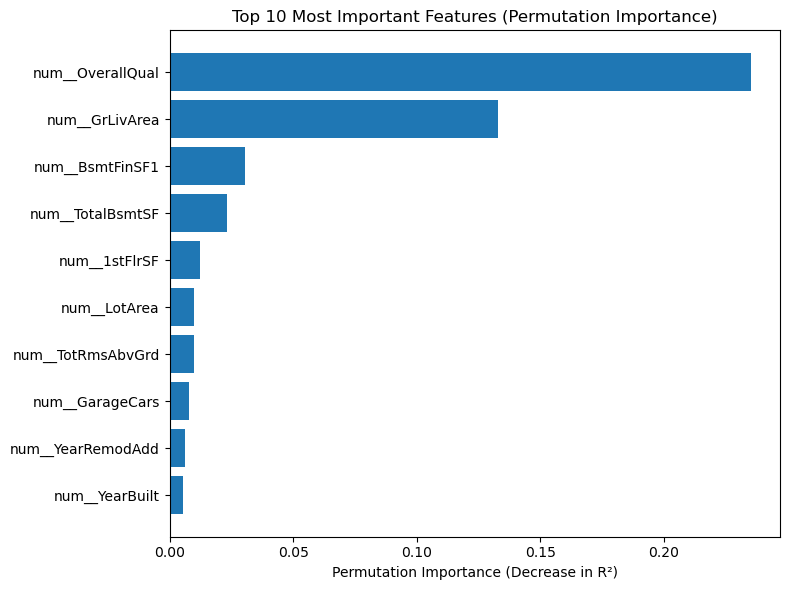

In [15]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Compute permutation importance on the test set
result = permutation_importance(
    XGB,          # trained model
    df_test,      # test features
    y_test,       # test labels
    n_repeats=10, # number of shuffles
    random_state=0,
    n_jobs=-1
)

# importance values (how much the score drops when a feature is shuffled)
importances = result.importances_mean

# sort by importance descending
idx = np.argsort(importances)[::-1]

# select top 10
top10_idx = idx[:10]
top10_features = feature_names[top10_idx]
top10_importances = importances[top10_idx]

# Plot
plt.figure(figsize=(8, 6))
plt.barh(top10_features[::-1], top10_importances[::-1])
plt.xlabel("Permutation Importance (Decrease in R²)")
plt.title("Top 10 Most Important Features (Permutation Importance)")
plt.tight_layout()
plt.show()


## Problem 2 (10 points)

As we discussed in class, XGBoost implements 5 different metrics to measure feature importance. Calculate all 5 metrics and create 5 figures showing the top 10 most important features for each metric.

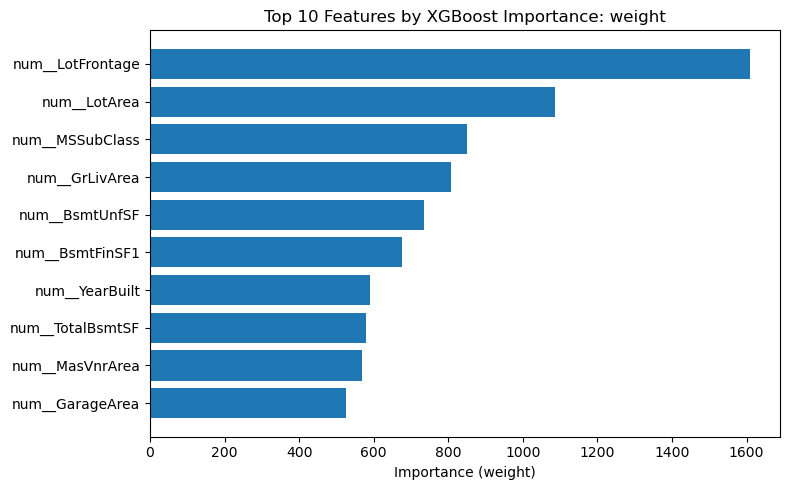

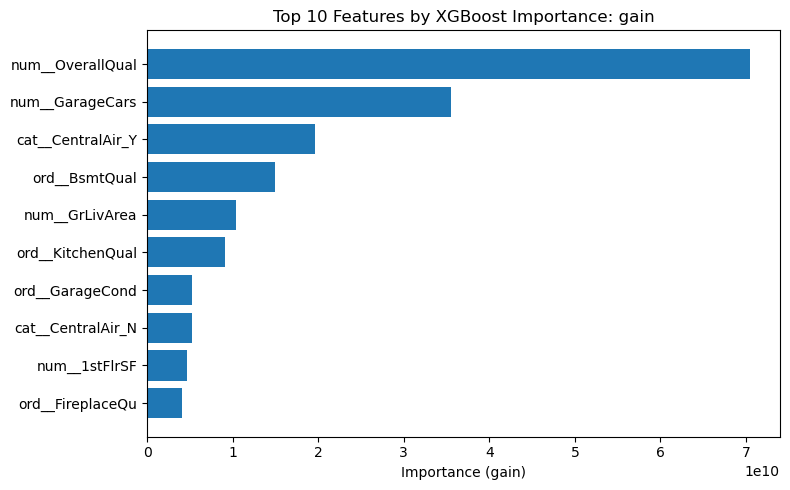

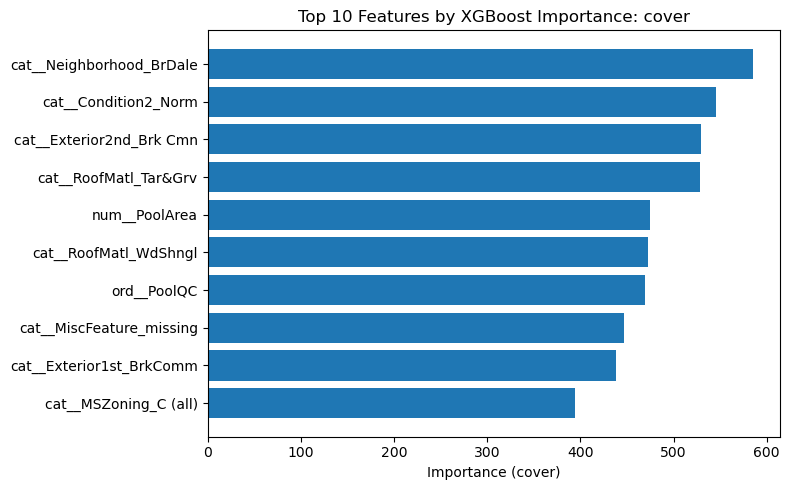

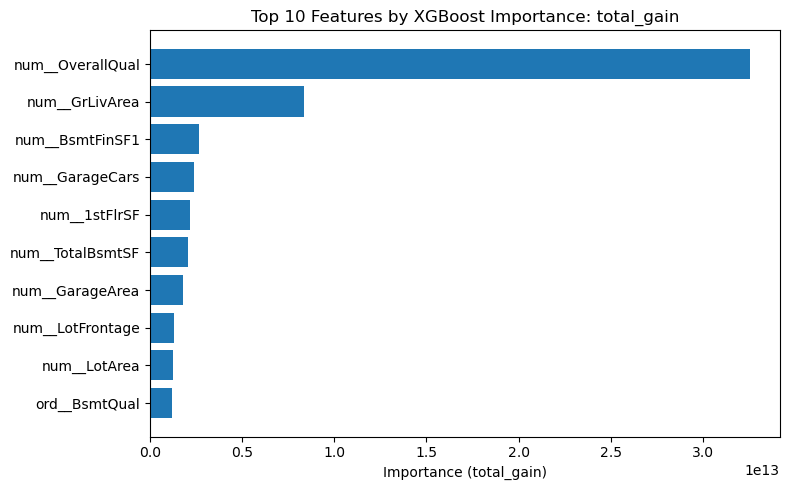

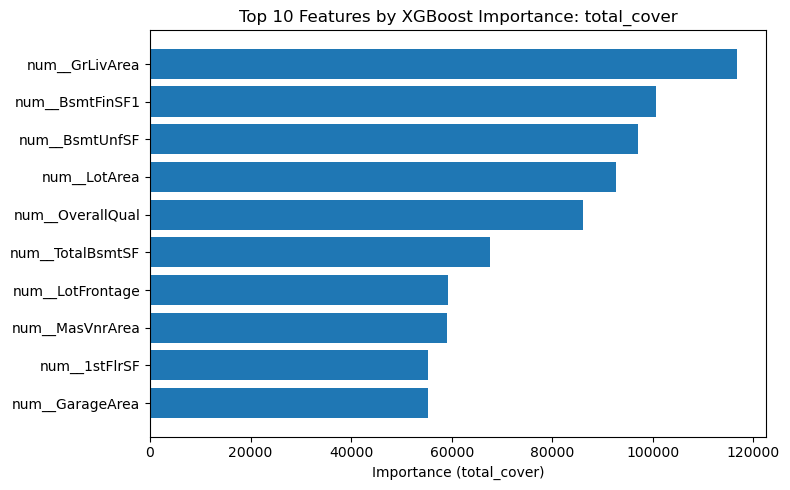

In [ ]:
# your code here
import matplotlib.pyplot as plt
import numpy as np

booster = XGB.get_booster()

importance_types = [
    "weight",
    "gain",
    "cover",
    "total_gain",
    "total_cover"]

for imp_type in importance_types:
    # get importance dictionary: {feature_name: score}
    score_dict = booster.get_score(importance_type=imp_type)
    
    # match names to full feature list (missing = 0)
    scores = np.array([score_dict.get(f, 0) for f in feature_names])

    # sort descending
    idx = np.argsort(scores)[::-1]
    top10 = idx[:10]

    # plot
    plt.figure(figsize=(8, 5))
    plt.barh(feature_names[top10][::-1], scores[top10][::-1])
    plt.title(f"Top 10 Features by XGBoost Importance: {imp_type}")
    plt.xlabel(f"Importance ({imp_type})")
    plt.tight_layout()
    plt.show()


## Problem 3a (10 points)

Let's now calculate the shap values of the test set points. Use the shap values to calculate global feature importance values and prepare a plot that shows the top 10 most important features. Choose one of the two approaches:

1) You can use the shap package as we did in class. You will encounter an error which you'll need to solve yourself. Please do not ask about this error on Ed Discussion. Instead, figure it out yourself. You'll also need to manually change some parameters of the plot.

2) XGBoost can directly calculate shap values for you (look up how) but you need to recreate the figures with matplotlib because XGBoost's shap values don't come with visualizations. 

Both approaches take roughly the same amount of time to work through. 

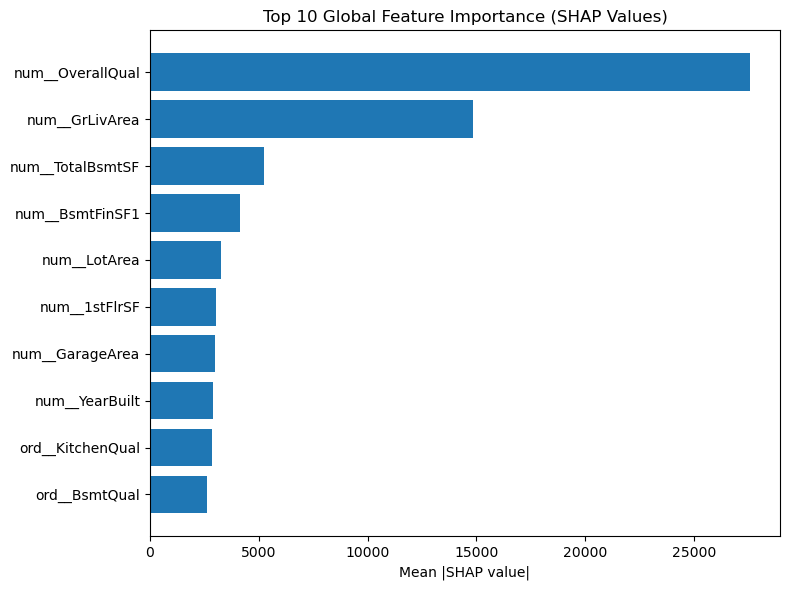

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Extract booster from the sklearn wrapper
booster = XGB.get_booster()
# Create SHAP explainer with the booster
explainer = shap.TreeExplainer(booster)
# Compute SHAP values for the test set
shap_values = explainer.shap_values(df_test.values)
# Compute global importance: mean absolute shap values
global_importance = np.mean(np.abs(shap_values), axis=0)
# Select top 10 features
idx = np.argsort(global_importance)[::-1]
top10_idx = idx[:10]

top10_features = feature_names[top10_idx]
top10_importance = global_importance[top10_idx]

# Plot Top 10 SHAP Global Importance
plt.figure(figsize=(8, 6))
plt.barh(top10_features[::-1], top10_importance[::-1])
plt.xlabel("Mean |SHAP value|")
plt.title("Top 10 Global Feature Importance (SHAP Values)")
plt.tight_layout()
plt.show()


## Problem 3b (10 points)

Let's take a look at some specific data points with indices 0, 100, and 200. For each data point, create a force plot and describe in a paragraph or two which features contribute positively and negatively to the prediction.

Index: 0


<Figure size 2000x600 with 0 Axes>

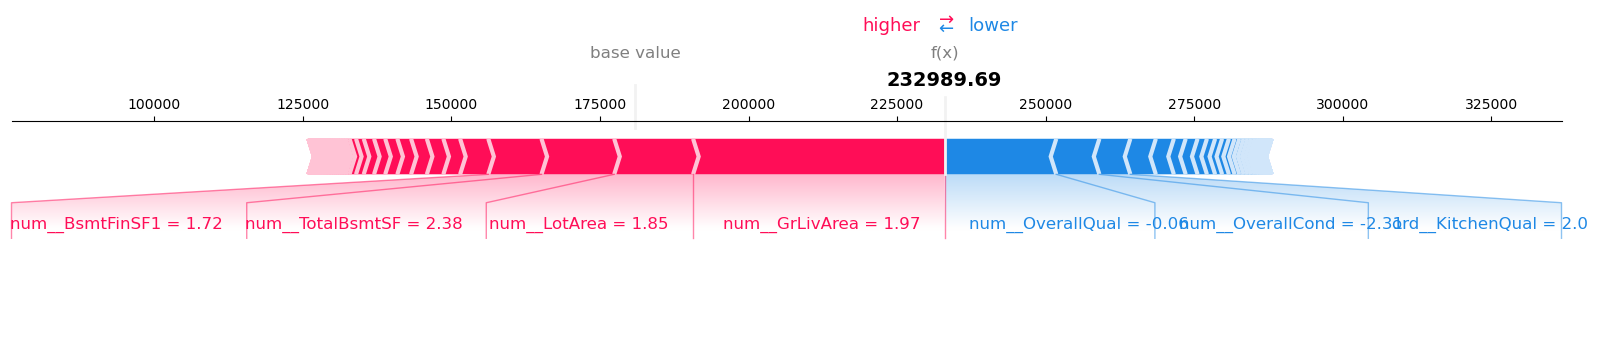

Index: 100


<Figure size 2000x600 with 0 Axes>

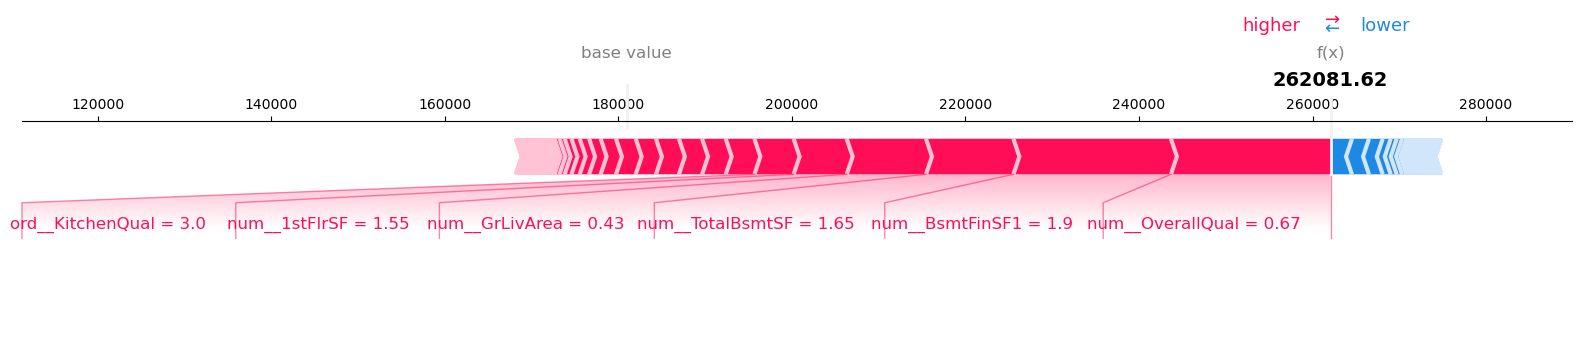

Index: 200


<Figure size 2000x600 with 0 Axes>

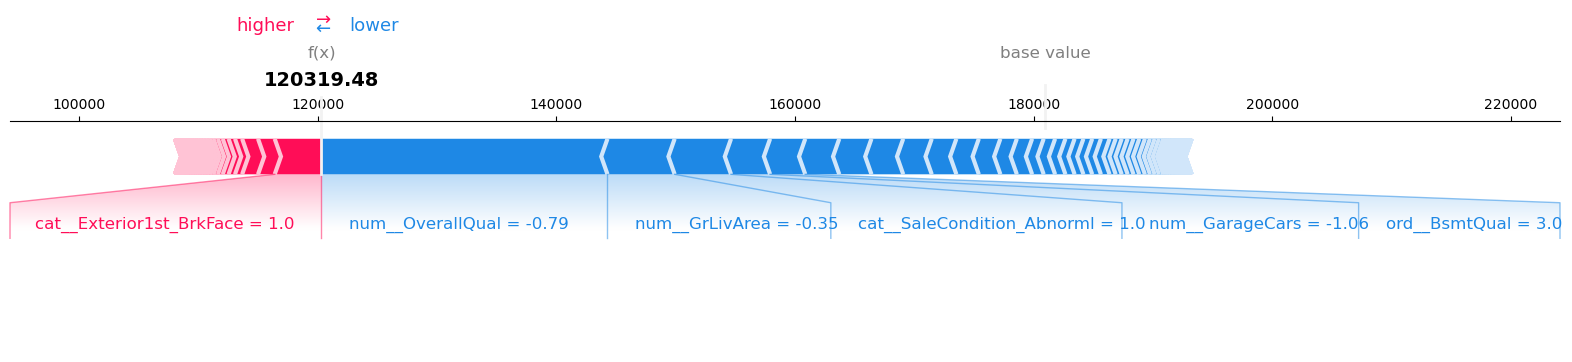

In [24]:
# your code here
import shap

# Force plot for a given index
def plot_force(idx):
    print('Index: ' + str(idx))
    df_test_rounded = df_test.round(2)
    plt.figure(figsize=(20, 6))
    shap.force_plot(
        explainer.expected_value,         # baseline prediction
        shap_values[idx],                 # shap values for this sample
        df_test_rounded.iloc[idx],                # raw feature values
        feature_names=feature_names,
        matplotlib=True                   # force matplotlib rendering (no JS)
    )

# Show force plots for index 0, 100, 200
plot_force(0)
plot_force(100)
plot_force(200)


**your explanation here**

For index 0, the predicted price exceeds the baseline mainly due to strong contributions from size-related features. BsmtFinSF1 (finished basement area, 1.72), TotalBsmtSF (total basement area, 2.38), LotArea (lot size, 1.85), and GrLivArea (above-ground living area, 1.97) all strongly push the prediction upward, indicating that the property benefits from generous land size and substantial usable living space. On the other hand, several quality-related variables pull the price downward. OverallQual (overall material/finish quality, –0.06), OverallCond (overall structural condition, –2.33), and KitchenQual (kitchen quality, –2.0) suggest that the home’s condition and finish level are moderate, which reduces some of the value gained from its large size.


For index 100, the predicted sale price is significantly above the baseline because the home performs exceptionally well in both quality and size. The strongest upward force comes from KitchenQual (kitchen quality, 3.0), indicating a high-end, well-finished kitchen that substantially increases the home's value. Additional positive effects come from 1stFlrSF (first-floor area, 1.55), GrLivArea (above-ground living space, 0.43), TotalBsmtSF (total basement area, 1.65), and BsmtFinSF1 (finished basement area, 1.90). These features collectively indicate a spacious, functional home. Because there are minimal negative contributions, the model predicts a much higher-than-baseline sale price.


For index 200, the predicted price falls well below the baseline because negative contributions outweigh the few positive ones. Although Exterior1st_BrkFace (brick exterior, 1.0) slightly increases the value, major downward forces dominate. BsmtQual (basement quality, –3.0) is the largest negative contributor, indicating a poorly constructed or low-quality basement. Additional declines come from OverallQual (overall material/finish quality, –0.79) and GrLivArea (living area, –0.35), suggesting modest space and average craftsmanship. SaleCondition_Abnorml (abnormal sale such as foreclosure, –1.0) and GarageCars (garage capacity, –1.06) also reduce the prediction. Overall, the home suffers from limited space, weaker structural quality, and unfavorable sale conditions, resulting in a much lower estimated price.

## Problem 4 (5 points)

You calculated 7 different global feature importance metrics (perturbation, 5 XGB metrics, global shap). Unfortunately the ranking of features can be quite different depending on the importance metric used. Write a short discussion on the similarities and differences amongst the 7 methods. Are there features that tend to be in the top 3-5 regardless of the approach used? Discuss the pros and cons of the various approaches!

**your explanation here**

In this assignment, we computed seven global feature importance metrics: permutation importance, the five XGBoost built-in metrics (weight, gain, cover, total_gain, total_cover), and global SHAP values. OverallQual (overall material and finish quality) and GrLivArea (above-ground living area) consistently appear in the top 3–5 features across nearly all metrics. This indicates that these variables are universally important structural determinants of house prices regardless of the evaluation method. Features such as TotalBsmtSF, BsmtFinSF1, and LotArea also frequently appear in the top ten, suggesting that size-related attributes generally exert strong influence on predictions.

Although these metrics produce different rankings, they share some similarities. All seven methods aim to quantify how much each feature contributes to the model, either by measuring predictive impact (permutation, SHAP) or by analyzing how the model internally uses the feature (XGBoost metrics). They all identify features that the model systematically relies on, which is why certain variables consistently appear near the top across multiple approaches. However, the differences among the seven methods are substantial. Permutation importance and SHAP represent perturbation-based methods. They examine how prediction quality or prediction values change when a feature is altered. These approaches capture the model’s true dependence on features, including interactions. In contrast, the five XGBoost metrics are model-internal and reflect how decision trees are constructed rather than how final predictions change. 

Permutation importance measures how much the model’s performance decreases after shuffling a feature. It is intuitive and reflects true model dependence, but it is computationally expensive and can be distorted by multicollinearity (correlated features may mask each other). In contrast, XGBoost’s five internal metrics reflect the model’s tree-building process. Weight counts how many times a feature is chosen as a split across all trees. This measure tends to favor features that are easy for the algorithm to split on—those with good numerical spread or stable patterns. As a result, weight may inflate the importance of features that frequently appear in splits even if each split contributes little to predictive accuracy. Gain, on the other hand, measures how much a feature reduces the loss function whenever it is used for a split. This makes gain more reflective of “true contribution”: a feature that appears rarely but creates a large performance improvement when it does appear will score highly. Total_gain aggregates gain across all trees, stabilizing the metric and reinforcing features with repeated meaningful contributions. Cover measures how many samples are affected by splits involving a given feature. Features whose split points lie in dense regions of the data (e.g., common categories or frequently occurring numeric ranges) will naturally have high cover, even if the split itself is not very informative. Total_cover accumulates these values across trees and further amplifies this bias. SHAP values, grounded in cooperative game theory, quantify both the magnitude and direction of each feature’s effect and account for feature interactions. SHAP provides the most interpretable results but is also the most computationally demanding.


## Interesting Note (no points, just for reading purposes)

You've probably noticed that, when working with SHAP on XGBoost, you can use either the model-agnostic "Explainer" or the tree-specific "Tree-Explainer". If you rememeber the math from class, this might be confusing: nowhere does the formula assume you're working with a tree, so why should SHAP care about the model you're working with?

The reason for this is **speed**. Recall that the formula for SHAP values is: $\Phi_i = \sum_{S\subseteq M\setminus i}  \frac{|S|!(M - |S| - 1)!} {M!} [f_x(S\cup i) - f_x(S)]$, where: 

- $\Phi_i$ - the contribution of feature $i$
- $M$ - the number of features
- $S$ - a set of features excluding $i$, a vector of 0s and 1s (0 if a feature is missing)
- $|S|$ - the number of features in $S$
- $f_x(S)$ - the prediction of the model with features $S$

For a tree-based method, calculating SHAP values with this method takes $O(TL2^M)$ time, with T = the number of trees, L = the max number of leaves in a tree, and M = the number of features. This is **extremely slow**, especially as M increases. 

However, in a [2018 paper](https://arxiv.org/abs/1802.03888), researchers developed a new strategy specifically for trees that runs in $O(TLD^2)$, with D the maximum depth of any tree. Notice: this new method **does not rely on the number of features**. Due to this exponential speed-up, SHAP values have become increasingly popular for explaining tree-based methods.